<a href="https://colab.research.google.com/github/ninja-marduk/ml_precipitation_prediction/blob/feature%2Fpreprocessing-techniques/notebooks/preprocessing_techniques_parallel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Configuración para ejecución local y en Google Colab
Este notebook está diseñado para ejecutarse tanto en un entorno local como en Google Colab. A continuación, se incluyen las configuraciones necesarias para ambos entornos.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.3/82.3 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 3.7 MB/s eta 0:00:00
  Attempting uninstall: dill
    Found existing installation: dill 0.3.7
    Uninstalling dill-0.3.7:
      Successfully uninstalled dill-0.3.7
  Attempting uninstall: multiprocess
    Found existing installation: multiprocess 0.70.15
    Uninstalling multiprocess-0.70.15:
      Successfully uninstalled multiprocess-0.70.15
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the followin

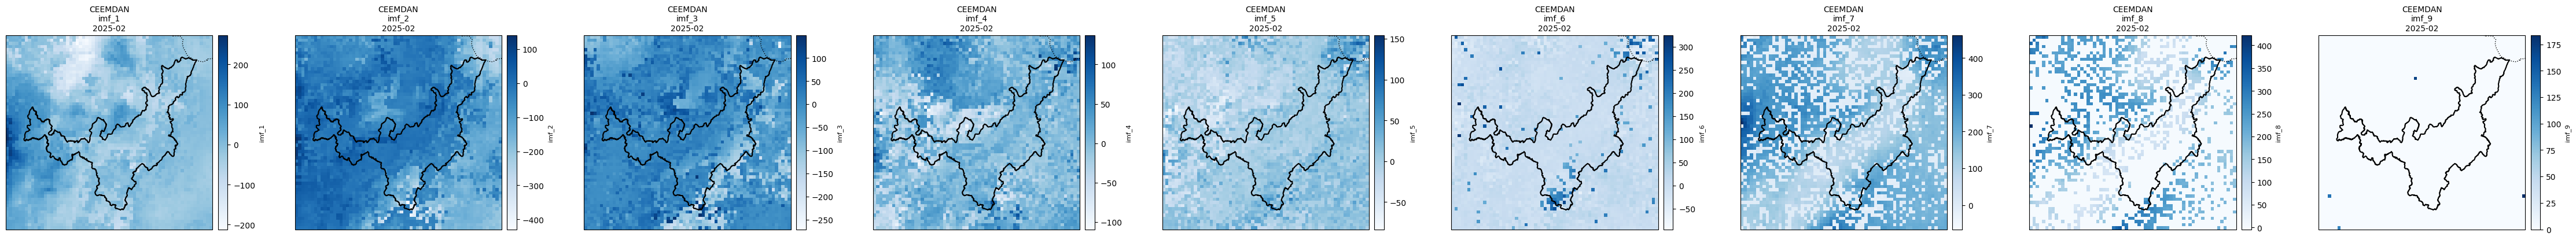

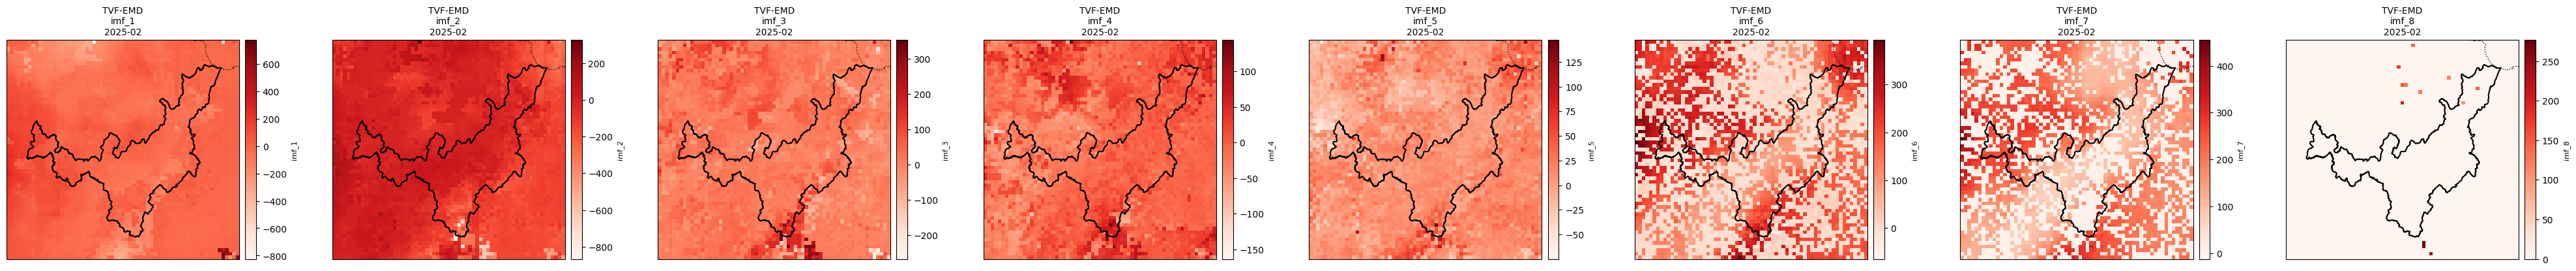

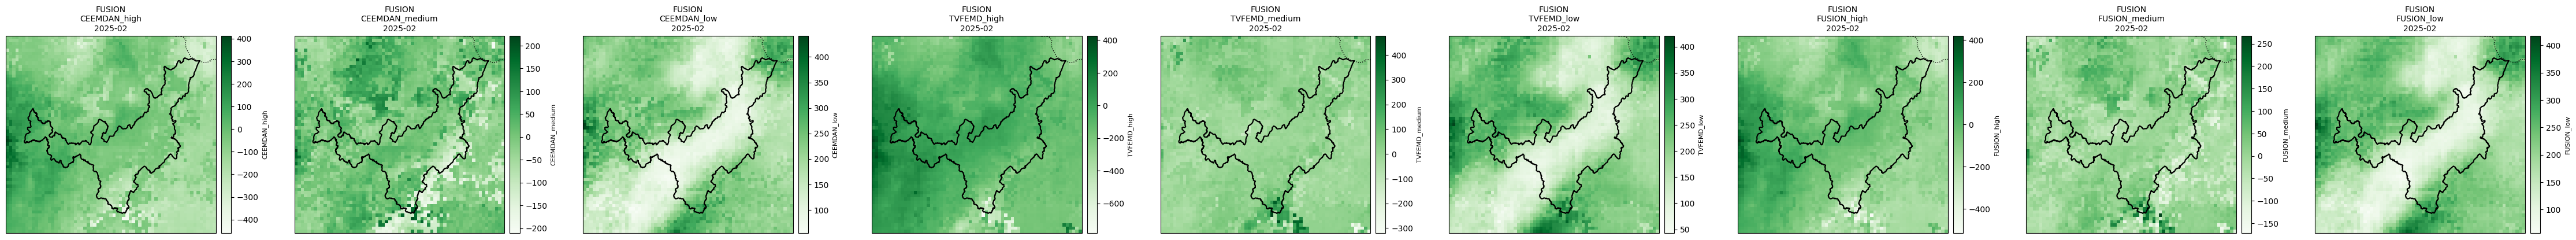


--- Head de ds_final ---
                                CEEMDAN_high  CEEMDAN_medium  CEEMDAN_low  \
time       latitude longitude                                               
1981-01-01 4.375    -74.925003    -89.989046       -3.385431   139.815353   
                    -74.875008    -91.865592       16.802804   122.665724   
                    -74.825005    -99.731312       20.592584   124.470393   
                    -74.775002    -87.339591       16.807652   110.082346   
                    -74.725006   -109.477080       31.431949   118.672511   
                    -74.675003    -93.881040       14.256124   122.733155   
                    -74.625008   -112.272066       23.465267   132.552744   
                    -74.575005   -125.758452       31.289342   136.658967   
                    -74.525002    -64.582777      -22.537746   137.504911   
                    -74.475006    -93.585103       13.858776   115.110044   

                                TVFEMD_high  TVFE

In [3]:
# =============================================================================
# 🚀 Pipeline CEEMDAN + TVF-EMD → high/med/low → fusión → NetCDF + gráficos
#    • Paralelizado con joblib + tqdm
#    • Detecta cores y RAM para ajustar n_jobs
#    • Workaround para evitar los resource_tracker errors en macOS
#    • Filtra warnings generales
#    • Overlay del límite de Boyacá en cada mapa
#    • Al final, impresión de head y estadísticas del NetCDF de fusión
# =============================================================================

import os
import sys
import logging
import warnings
from pathlib import Path

# — Suprimir warnings innecesarios —
warnings.filterwarnings("ignore")

# — Workaround para evitar el error “No child processes” de resource_tracker en macOS —
try:
    import multiprocessing.resource_tracker as rt
    rt.ResourceTracker._stop = lambda self: None
    logging.getLogger(__name__).info("🔧 resource_tracker monkey-patched.")
except ImportError:
    pass

# 1) Entorno (Colab vs. local)
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    BASE_PATH = Path('/content/drive/MyDrive/ml_precipitation_prediction')
    # instalar solo lo necesario
    !pip install xarray netCDF4 PyEMD emd cartopy EMD-signal psutil
else:
    BASE_PATH = Path.cwd()
    for p in [BASE_PATH, *BASE_PATH.parents]:
        if (p / '.git').exists():
            BASE_PATH = p
            break

print(f"▶️ Usando ruta base: {BASE_PATH}")

# 2) Rutas
model_output_dir = BASE_PATH / 'models' / 'output'
model_output_dir.mkdir(parents=True, exist_ok=True)
data_file        = BASE_PATH / 'data' / 'output' / 'complete_dataset_with_features_with_clusters_elevation_with_windows.nc'
ceemdan_nc       = model_output_dir / 'features_CEEMDAN.nc'
tvfemd_nc        = model_output_dir / 'features_TVFEMD.nc'
fusion_nc        = model_output_dir / 'features_fusion_branches.nc'
boyaca_shp       = BASE_PATH / 'data' / 'input' / 'shapes' / 'MGN_Departamento.shp'

# 3) Logger
logging.basicConfig(level=logging.INFO, format="%(asctime)s %(levelname)s %(message)s")
logger = logging.getLogger(__name__)

# 4) Librerías de proceso
import xarray as xr
import numpy as np
from PyEMD import CEEMDAN
from emd import sift
from joblib import Parallel, delayed, cpu_count
from tqdm.auto import tqdm
import psutil

# Para lectura de shapefile
import geopandas as gpd

# Para plots
import matplotlib.pyplot as plt
import cartopy.crs  as ccrs
import cartopy.feature as cfeature

# -----------------------------------------------------------------------------
# 5) Detectar n_jobs según cores y RAM
# -----------------------------------------------------------------------------
total_cores  = cpu_count()
avail_ram_gb = psutil.virtual_memory().available / (1024**3)
if avail_ram_gb < 2:
    n_jobs = 1
elif avail_ram_gb < 8:
    n_jobs = max(1, total_cores // 2)
else:
    n_jobs = max(1, total_cores - 1)

logger.info(f"🔧 Paralelismo: usando n_jobs={n_jobs} (cores={total_cores}, RAM libre≈{avail_ram_gb:.1f}GB)")

# -----------------------------------------------------------------------------
# 6) Función paralela para generar IMFs y guardarlos en un NetCDF
# -----------------------------------------------------------------------------
def generate_imf_netcdf_parallel(method: str, monthly: xr.DataArray, out_path: Path):
    logger.info(f"▶️ Iniciando descomposición {method} en paralelo…")
    ce = CEEMDAN()
    lats, lons = monthly.latitude.values, monthly.longitude.values
    T = monthly.sizes['time']

    def _process_point(i, j, lat, lon):
        ts = monthly.sel(latitude=lat, longitude=lon).values.astype(float)
        if np.all(np.isnan(ts)) or np.all(ts == 0):
            return None
        try:
            raw = ce.ceemdan(ts) if method == 'CEEMDAN' else sift.sift(ts, max_imfs=8)
            arr = np.array(raw)
            if arr.ndim == 2 and arr.shape[0] == T and arr.shape[1] != T:
                arr = arr.T
            assert arr.ndim == 2 and arr.shape[1] == T
            return (i, j, arr)
        except Exception:
            logger.warning(f"⚠️ {method} falló en ({lat:.3f},{lon:.3f})", exc_info=True)
            return None

    tasks = [(i, j, lat, lon)
             for i, lat in enumerate(lats)
             for j, lon in enumerate(lons)]

    results = Parallel(n_jobs=n_jobs, verbose=5)(
        delayed(_process_point)(i, j, lat, lon) for i, j, lat, lon in tasks
    )

    imf_dict = {}
    for res in tqdm(results, desc=f"Assembling IMFs {method}"):
        if res is None:
            continue
        i, j, arr = res
        for k in range(arr.shape[0]):
            imf_dict.setdefault(k+1, np.zeros((T, len(lats), len(lons)), dtype=float))
            imf_dict[k+1][:, i, j] = arr[k]

    if not imf_dict:
        raise RuntimeError(f"No se generó ninguna IMF para {method}")

    data_vars = {
        f"imf_{k}": (("time", "latitude", "longitude"), v)
        for k, v in imf_dict.items()
    }
    ds_out = xr.Dataset(data_vars,
                        coords={"time": monthly.time.values,
                                "latitude": lats,
                                "longitude": lons})
    ds_out.to_netcdf(out_path)
    logger.info(f"💾 Guardado NetCDF IMFs {method}: {out_path.name}")

# -----------------------------------------------------------------------------
# 7) Asegurar NetCDFs de CEEMDAN y TVF-EMD
# -----------------------------------------------------------------------------
try:
    ds0    = xr.open_dataset(data_file)
    precip = ds0['total_precipitation']
    difs   = np.diff(precip.time.values) / np.timedelta64(1, 'D')
    monthly= (precip if np.median(difs) > 2 else precip.resample(time='1M').sum())\
                .load().fillna(0)

    for method, out_path in [('CEEMDAN', ceemdan_nc), ('TVF-EMD', tvfemd_nc)]:
        if out_path.exists():
            logger.info(f"⏩ {out_path.name} ya existe. Omitiendo {method}.")
        else:
            generate_imf_netcdf_parallel(method, monthly, out_path)

except Exception:
    logger.exception("❌ Error generando NetCDFs de IMFs.")

# -----------------------------------------------------------------------------
# 8) Cargar los datasets resultantes
# -----------------------------------------------------------------------------
try:
    ds_C = xr.open_dataset(ceemdan_nc)
    ds_T = xr.open_dataset(tvfemd_nc)
except Exception:
    logger.exception("❌ No se pudieron cargar los NetCDF de IMFs.")
    sys.exit(1)

# -----------------------------------------------------------------------------
# 9) Agrupar en ramas high/medium/low por método
# -----------------------------------------------------------------------------
def make_branches(ds: xr.Dataset, prefix: str):
    ivars = sorted(ds.data_vars, key=lambda v: int(v.split('_')[1]))
    return {
        f"{prefix}_high":   sum(ds[v]   for v in ivars[:2]),
        f"{prefix}_medium": sum(ds[v]   for v in ivars[2:4]),
        f"{prefix}_low":    sum(ds[v]   for v in ivars[4:]),
    }

br_C = make_branches(ds_C, 'CEEMDAN')
br_T = make_branches(ds_T, 'TVFEMD')

# -----------------------------------------------------------------------------
# 10) Fusión lineal α=0.5
# -----------------------------------------------------------------------------
alpha = 0.5
br_F = {
    f"FUSION_{lvl}": alpha*br_C[f"CEEMDAN_{lvl}"] + (1-alpha)*br_T[f"TVFEMD_{lvl}"]
    for lvl in ['high','medium','low']
}

# -----------------------------------------------------------------------------
# 11) Construir y guardar NetCDF final de ramas
# -----------------------------------------------------------------------------
try:
    ds_final = xr.Dataset({**br_C, **br_T, **br_F}, coords=ds_C.coords)
    ds_final.to_netcdf(fusion_nc)
    logger.info(f"💾 NetCDF final guardado: {fusion_nc.name}")
except Exception:
    logger.exception("❌ Error guardando NetCDF final de fusión.")

# -----------------------------------------------------------------------------
# 12) Leer shapefile de Boyacá
# -----------------------------------------------------------------------------
shp_dep = gpd.read_file(boyaca_shp)
geoms   = shp_dep.geometry.values

# -----------------------------------------------------------------------------
# 13) Función de plot para mapas de IMFs y ramas (con overlay Boyacá y colormaps distintos)
# -----------------------------------------------------------------------------
def plot_imfs(ds: xr.Dataset, title: str, cmap: str):
    t0   = ds.time.values[-1]
    date = np.datetime_as_string(t0, unit='M')
    vars_ = list(ds.data_vars)
    n    = len(vars_)
    fig, axs = plt.subplots(
        1, n, figsize=(5*n, 4),
        subplot_kw={'projection': ccrs.PlateCarree()}
    )
    if n == 1:
        axs = [axs]
    for ax, var in zip(axs, vars_):
        arr = ds[var].sel(time=t0)
        mesh = ax.pcolormesh(
            ds.longitude, ds.latitude, arr,
            cmap=cmap, shading='nearest',
            transform=ccrs.PlateCarree()
        )
        ax.coastlines()
        ax.add_feature(cfeature.LAND, facecolor='lightgray')
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        # overlay Boyacá
        ax.add_geometries(geoms, crs=ccrs.PlateCarree(),
                          edgecolor='black', facecolor='none', linewidth=1.5)
        ax.set_title(f"{title}\n{var}\n{date}", fontsize=10)
        cbar = fig.colorbar(mesh, ax=ax, orientation='vertical', pad=0.02)
        cbar.set_label(var, fontsize=8)
    plt.tight_layout()
    out = model_output_dir / f"{title.replace('+','')}_branches_{date}.png"
    fig.savefig(out, dpi=150)
    plt.show()
    logger.info(f"💾 Mapa {title} guardado: {out.name}")

# -----------------------------------------------------------------------------
# 14) Dibujar CEEMDAN, TVF-EMD y FUSION con colormaps específicos
# -----------------------------------------------------------------------------
plot_imfs(ds_C,     "CEEMDAN", cmap='Blues')
plot_imfs(ds_T,     "TVF-EMD", cmap='Reds')
plot_imfs(ds_final, "FUSION",  cmap='Greens')

# -----------------------------------------------------------------------------
# 15) Mostrar head y estadísticas del dataset de fusión
# -----------------------------------------------------------------------------
print("\n--- Head de ds_final ---")
print(ds_final.to_dataframe().head(10))

print("\n--- Estadísticas descriptivas de ds_final ---")
print(ds_final.to_dataframe().describe())

print("\n✅ Proceso completo con gráficos, trazabilidad y paralelo.")
